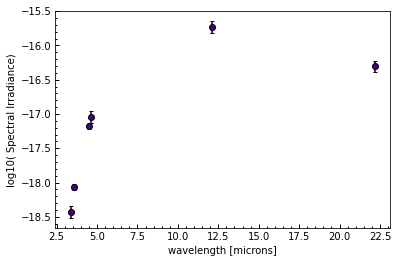

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from astropy.io import ascii
import scipy.constants as con
import scipy.stats as stat
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from decimal import Decimal

data = np.genfromtxt('data_2.dat')
lam = data[:,0]
logf = data[:,1]
errlogf = data[:,2]
#h = con.h
#c = con.c
#k = con.k
c = 3*10**8 #do constants manually
h = 6.626*10**(-34)
k = 1.381*10**(-23)
#ASSIGMENT 2 DATA

#Column 1 = wavelength [microns]
#Column 2 = log10( Spectral Irradiance [erg s^-1 cm^-1 A^-1] )
#Column 3 = error on column 2



#Plot data
fig, ax = plt.subplots()
plt.errorbar(lam, logf, errlogf,
             fmt='o', markerfacecolor='indigo', markeredgecolor='black', ecolor='black', capsize=2)
plt.xlabel('wavelength [microns]')
plt.ylabel('log10( Spectral Irradiance)')

def setaxparams(): #axis formatting stuff
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=1, direction='in')
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2, direction='in')
setaxparams()

params = {'mathtext.default': 'regular', 'font.family':'monospace'} #label formatting stuff
plt.rcParams.update(params)

In [2]:
# Set a definition for the model
def model(microns, Teff, logfactor):
    microns_scaled = np.copy(microns)*10**(-6) #scale to meters to match units of constant
    logflux = logfactor + np.log10(2*h*c**2) + np.log10((microns_scaled**(-5))/(np.exp(h*c/(microns_scaled*k*Teff))-1.))
    #Coded in logplanck
    return logflux

Text(0, 0.5, 'log10( Spectral Irradiance)')

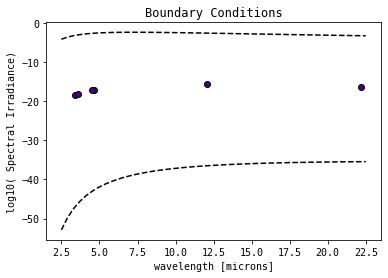

In [3]:
model_high = model(np.linspace(2.5, 22.5, num = 50), 400, -10)
model_low = model(np.linspace(2.5, 22.5, num = 50), 100, -40)
#data for planck lines of upper and lower bounds to parameters

fig, ax = plt.subplots()
plt.errorbar(lam, logf, errlogf,
             fmt='o', markerfacecolor='indigo', markeredgecolor='black', ecolor='black', capsize=2)
plt.plot(np.linspace(2.5, 22.5, num = 50), model_high, color='black', linestyle='--')
plt.plot(np.linspace(2.5, 22.5, num = 50), model_low, color='black', linestyle='--')
plt.title('Boundary Conditions')
plt.xlabel('wavelength [microns]')
plt.ylabel('log10( Spectral Irradiance)')

In [4]:
def log_like(lam, logf, errlogf, theta):
    Teff = theta[0]
    logfactor = theta[1]
    log_independent_terms = -0.5*(np.log(2*np.pi))*len(lam)-np.sum(np.log(errlogf))
    #constant terms. They are not significant in the MCMC,
    #but they make it easier to find the max loglikelihood later
    loglike = -0.5*np.sum(((model(lam, Teff, logfactor)-logf)/errlogf)**2) + log_independent_terms

    return loglike

In [5]:
def log_prior(theta):
    
    # Prior for theta[0]: Teff~logU[Teffmin, Teffmax]
    log_prior_0 = np.log(1/((theta[0])*np.log(400/100)))
    # Prior for theta[1]: logfac~U[logfacmin,logfacmax]
    log_prior_1 = np.log(1/30)
    #logprior = np.sum(logpriors)
    return np.array(log_prior_0, log_prior_1)

In [6]:
# Initialize the MCMC from a random point drawn from the prior
theta_seed = [np.exp(np.random.uniform(np.log(100), np.log(400))), np.random.uniform(-40, -10)]

#calculate the associated modified loglike
log_like_seed = log_like(lam, logf, errlogf, theta_seed)
print (theta_seed)

[174.0887301406842, -18.376801572086897]


In [7]:
#define the proposal jump size
jump_size = [1, .05]

def run_mcmc(theta_seed, jump_size):
    # Starting walking 
    j = 0
    jmax = 50000
    theta_chain = np.copy(theta_seed)
    theta_0 = np.copy(theta_seed)
    log_like_0 = log_like(lam, logf, errlogf, theta_0)
    log_like_chain = np.copy(log_like_0)
    while True:
        #generate a proposal (or jump):
        #theta_prime = [theta_0[0]+np.random.normal(0, 1), theta_0[1]+np.random.normal(0,.05)]
        log_like_0 = log_like(lam, logf, errlogf, theta_0)
        theta_prime = [theta_0[0]+np.random.normal(0,jump_size[0]), theta_0[1]+np.random.normal(0,jump_size[1])]
        #Compute Metropolis Rule:
        log_like_prime = log_like(lam, logf, errlogf, theta_prime)
        log_like_delta = log_like_prime - log_like(lam, logf, errlogf, theta_0)
        log_prior_delta = log_prior(theta_prime)-log_prior(theta_0)
        #probjump = np.minimum(1, np.exp(log_like_delta, dtype = np.float128))
        probjump = np.minimum(1, np.exp(log_like_delta + log_prior_delta))
        if probjump>np.random.uniform(0,1):
            # accept the jump
            j = j+1
            log_like_chain = np.append(log_like_chain, log_like_prime)
            theta_chain = np.vstack((theta_chain, theta_prime))
            theta_0 = theta_prime   
        else:
            j = j+1 #append failed trials
            log_like_chain = np.append(log_like_chain, log_like_0)
            theta_chain = np.vstack((theta_chain, theta_0))    
        if j == jmax:
            break
    return log_like_chain, theta_chain

In [8]:
%matplotlib inline 

#set up main MCMC run
first_mcmc = run_mcmc(theta_seed, jump_size)
first_theta_chain = first_mcmc[1]

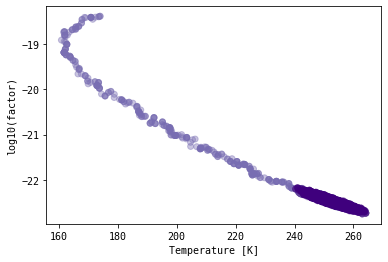

In [9]:
jlist=np.arange(len(first_theta_chain))#show graph of how MCMC is walking with parameters
plt.scatter(first_theta_chain[:,0], first_theta_chain[:,1], c = jlist, cmap='Purples', vmin=-60000., vmax=30000., alpha=0.4)
plt.xlabel('Temperature [K]')
plt.ylabel('log10(factor)')
plt.show()

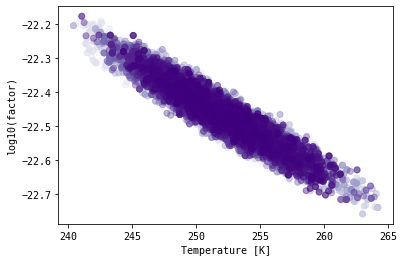

In [10]:
burnj = 1500 #above graph but with the burn-in cut off
plt.scatter(first_theta_chain[burnj:,0], first_theta_chain[burnj:,1], c = np.arange(len(first_theta_chain[burnj:,0])),
            cmap='Purples',  alpha=0.4)
plt.xlabel('Temperature [K]')
plt.ylabel('log10(factor)')
plt.show()

In [11]:
first_log_like_chain = first_mcmc[0] #calculate the max loglike, and from there the max likelihood
max_log_like = np.max(first_log_like_chain)
print('Maximum LogLikelihood: ', max_log_like)
print('Maximum likelihood: ', np.exp(max_log_like))

Maximum LogLikelihood:  8.602397416317617
Maximum likelihood:  5444.697162697616


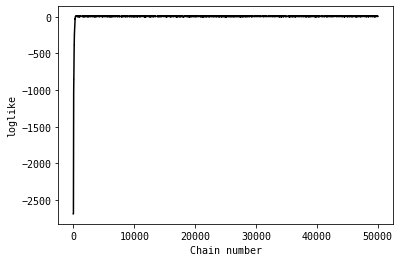

In [12]:
%matplotlib inline 
#show progression of log likelihood
plt.plot(first_log_like_chain, color='black')
plt.xlabel('Chain number')
plt.ylabel('loglike')
plt.show()

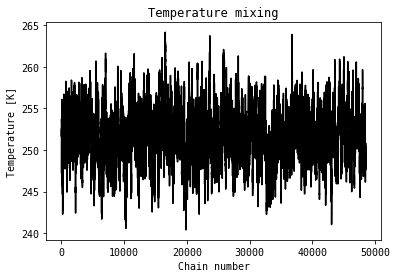

In [13]:
%matplotlib inline

burnj = 1500 #cut off burn-in, show mixing with temperature
plt.plot(first_theta_chain[burnj:, 0], color='black')
plt.title('Temperature mixing')
plt.xlabel('Chain number')
plt.ylabel('Temperature [K]')
plt.show()

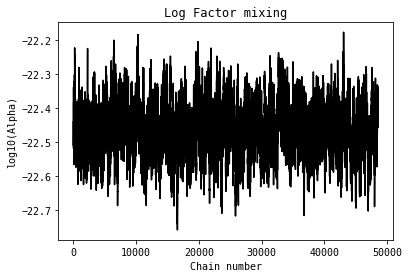

In [14]:
%matplotlib inline

#mixing with log factor
plt.plot(first_theta_chain[burnj:, 1], color='black')
plt.title('Log Factor mixing')
plt.xlabel('Chain number')
plt.ylabel('log10(Alpha)')
plt.show()

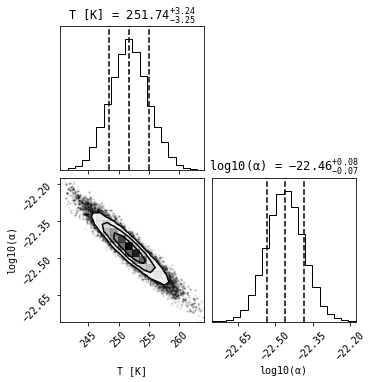

In [15]:
import corner #create corner plot to determine temperature, logfactor, and correlation
figure = corner.corner(first_theta_chain[burnj:], labels = ['T [K]', 'log10(α)'], quantiles = [.16, .5, .84], show_titles=True)

In [16]:
#Use the fact that the mcmc is now a function to perform 5 trials from different areas of
#our allowed range. Each trial will be graphed in a different color.
mcmc_cyan = run_mcmc([101, -39], jump_size)
mcmc_mag = run_mcmc([399, -39], jump_size)
mcmc_yellow = run_mcmc([399, -11], jump_size)
mcmc_black = run_mcmc([101, -11], jump_size)
mcmc_green = run_mcmc([101, -30], jump_size)

<ipython-input-7-43e8be31d997>:22: RuntimeWarning: overflow encountered in exp
  probjump = np.minimum(1, np.exp(log_like_delta + log_prior_delta))


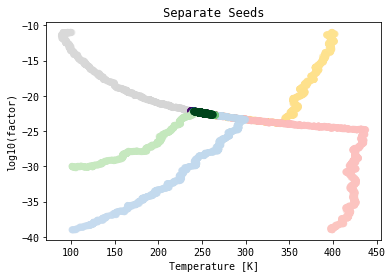

In [17]:
#graphing of each color

jlist=np.arange(len(mcmc_black[1]))
plt.scatter(mcmc_black[1][:,0], mcmc_black[1][:,1], c = jlist, cmap='Greys', vmin=-10000., vmax=30000., alpha=0.4)

jlist=np.arange(len(mcmc_yellow[1]))
plt.scatter(mcmc_yellow[1][:,0], mcmc_yellow[1][:,1], c = jlist, cmap='YlOrBr', vmin=-10000., vmax=30000., alpha=0.4)

jlist=np.arange(len(mcmc_mag[1]))
plt.scatter(mcmc_mag[1][:,0], mcmc_mag[1][:,1], c = jlist, cmap='RdPu', vmin=-10000., vmax=30000., alpha=0.4)

jlist=np.arange(len(mcmc_cyan[1]))
plt.scatter(mcmc_cyan[1][:,0], mcmc_cyan[1][:,1], c = jlist, cmap='Blues', vmin=-10000., vmax=30000., alpha=0.4)

jlist=np.arange(len(mcmc_green[1]))

plt.scatter(mcmc_green[1][:,0], mcmc_green[1][:,1], c = jlist, cmap='Greens', vmin=-10000., vmax=30000., alpha=0.4)
plt.title('Separate Seeds')
plt.xlabel('Temperature [K]')
plt.ylabel('log10(factor)')
plt.show()

Text(0, 0.5, 'log10( Spectral Irradiance)')

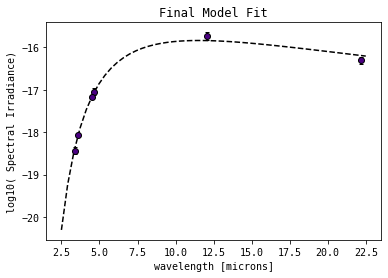

In [18]:
fig, ax = plt.subplots()
plt.errorbar(lam, logf, errlogf,
             fmt='o', markerfacecolor='indigo', markeredgecolor='black', ecolor='black', capsize=2)
plt.plot(np.linspace(2.5, 22.5, num = 50), model(np.linspace(2.5, 22.5, num = 50), 251.5, -22.45), color='black', linestyle='--')
plt.title('Final Model Fit')
plt.xlabel('wavelength [microns]')
plt.ylabel('log10( Spectral Irradiance)')

log$[2h\alpha c^2] = $log$[2hc^2] + $log$[\alpha]$